# Image Style Transfer Using Convolutional Neural Networks

## 0. Paper

### Info
* TItle : Image Style Transfer Using Convolutional Neural Networks
* Author : Leon A. Gatys et al.
* Link : https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf

### Summary
* pre-trained CNN을 활용해 이미지의 content/style 정보 추출
* content 이미지의 content, style 이미지의 style 정보와 가깝도록 이미지 학습

### Features
* 이미지 변경
* content feature layer 변경 : block4_conv2 -> block5_conv2

## 1. Setting

In [ ]:
# Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import cv2

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K

In [128]:
# Hyperparameters
CONFIG = {
    'base_dir' : '/content/drive/Shared drives/Yoon/Project/Doing/Deep Learning Paper Implementation',
    'style_weight' : 1e-1,
    'content_weight' : 1e3,
    'step_size' : 30
}

## 2. Data

In [8]:
def load_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image.astype(np.float32) / 255
    image = image[None]
    return image

In [ ]:
style_image_url = 'https://img1.daumcdn.net/thumb/R1280x0.fjpg/?fname=http://t1.daumcdn.net/brunch/service/user/145b/image/lx2U0K3AnrsBhy12f_p-UDNg-3c.jpg'
content_image_url = 'https://admission-global.skku.edu/bbs/filedown.php?bbsid=global_gallery_eng&file_seq=7236'

!curl $"{style_image_url}" > 'style_image.jpg'
!curl $"{content_image_url}" > 'content_image.jpg'

In [89]:
style_image = load_image('style_image.jpg')
content_image = load_image('content_image.jpg')

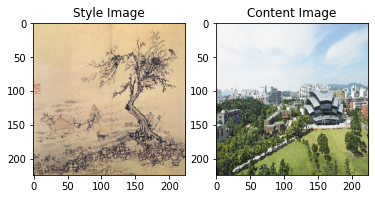

In [90]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(style_image[0])
ax[1].imshow(content_image[0])

ax[0].set_title('Style Image')
ax[1].set_title('Content Image')

plt.show()

## 3. Model

In [91]:
class Model(tf.keras.Model):
    def __init__(self, style_layers, content_layers):
        super().__init__()
        self.vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        self.vgg.trainable = False        
        self.style_layers = [self.get_layer(i) for i in style_layers]
        self.content_layers = [self.get_layer(i) for i in content_layers]

    def get_layer(self, layer_name):
        layer = tf.keras.Model(
            inputs = self.vgg.input,
            outputs = self.vgg.get_layer(layer_name).output)
        return layer
    
    def get_gram(self, inputs):
        gram = tf.linalg.einsum('bijc,bijd->bcd', inputs, inputs)
        scale = tf.cast(2 * gram.shape[1] * gram.shape[2], tf.float32)
        return gram / scale

    def call(self, x):
        x = x * 255
        x = tf.keras.applications.vgg19.preprocess_input(x)
        style_repr = [i(x) for i in self.style_layers]
        style_repr = [self.get_gram(i) for i in style_repr]
        content_repr = [i(x) for i in self.content_layers]
        return style_repr, content_repr

In [110]:
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layers = ['block5_conv2']
model = Model(style_layers, content_layers)

In [111]:
style_repr, _ = model(style_image)
_, content_repr = model(content_image)

## 4. Train

In [129]:
def loss_fn(real, pred):
    return tf.reduce_mean(tf.math.square(real - pred))

def clip_image(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

@tf.function
def train_step(image):    
    with tf.GradientTape() as tape:
        _style_repr, _content_repr = model(image)
        content_loss = tf.add_n([loss_fn(c, _c) for c, _c in zip(content_repr, _content_repr)])
        content_loss /= len(content_layers)
        style_loss = tf.add_n([loss_fn(s, _s) for s, _s in zip(style_repr, _style_repr)])
        style_loss /= len(style_layers)
        loss = CONFIG['content_weight'] * content_loss + CONFIG['style_weight'] * style_loss

    gradients = tape.gradient(loss, image)
    optimizer.apply_gradients([(gradients, image)])
    image.assign(clip_image(image))
    return loss, style_loss, content_loss

In [130]:
image = tf.Variable(np.random.rand(1, 224, 224, 3))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [ ]:
for st in range(1000):
    loss, style_loss, content_loss = train_step(image)
    if st % 100 == 0:
        print('=' * 50)
        print(f'STEP : {str(st).zfill(4)}')
        plt.imshow(image[0])
        plt.show()

## 5. Test

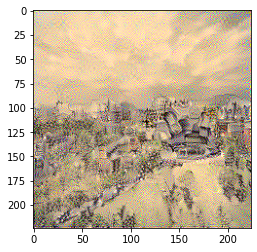

In [132]:
plt.imshow(image[0])
plt.show()